In [1]:
# https://towardsdatascience.com/hands-on-introduction-to-reinforcement-learning-in-python-da07f7aaca88

import numpy as np
import matplotlib.pyplot as plt

In [2]:
ACTIONS = {'U': (-1, 0), 'D': (1, 0), 'L': (0, -1), 'R': (0, 1)}

In [21]:
# the 1s represent walls and the 2 represents the robot’s position

class Maze(object):
    
    def __init__(self):
        # start with defining your maze
        self.maze = np.zeros((6, 6))
        self.maze[0, 0] = 2
        self.maze[5, :5] = 1
        self.maze[:4, 5] = 1
        self.maze[2, 2:] = 1
        self.maze[3, 2] = 1
        self.robot_position = (0, 0) # current robot position
        self.steps = 0 # contains num steps robot took
        self.allowed_states = None # updated when calling the self.construct_allowed_states()
        self.construct_allowed_states()
    
    def is_allowed_move(self, state, action): # returns false if the robot hits a wall or exits the maze
        y, x = state
        y += ACTIONS[action][0]
        x += ACTIONS[action][1]
        # moving off the board
        if y < 0 or x < 0 or y > 5 or x > 5:
             return False
        # moving into start position or empty space
        if self.maze[y, x] == 0 or self.maze[y, x] == 2:
            return True
        else:
            return False
    
    def construct_allowed_states(self):
        allowed_states = {}
        for y, row in enumerate(self.maze):
            for x, col in enumerate(row):
                # iterate through all valid spaces
                if self.maze[(y,x)] != 1: # check if the (y,x) is not a wall
                    allowed_states[(y,x)] = [] # and create the key of the dictionary as a (y,x)
                    for action in ACTIONS:
                        if self.is_allowed_move((y, x), action): # check which move is allowed from all possible actions
                            allowed_states[(y,x)].append(action) # and add these possible moves as values to the correspondent key
        self.allowed_states = allowed_states
    
    def update_maze(self, action):
        y, x = self.robot_position
        self.maze[y, x] = 0 # set the current position to empty (it was 2 before)
        y += ACTIONS[action][0]
        x += ACTIONS[action][1]
        self.robot_position = (y, x)
        self.maze[y, x] = 2 # set the new position to empty (it was 0 before)
        self.steps += 1
        
    def isGameOver(self):
        if self.robot_position == (5, 5):
            return True
        return False
    
    # We penalize -1 for every step the robot takes (as we want the fastest solution, not just any solution) and then reward 0 points when the robot reaches the end.
    def give_reward(self):
        if self.robot_position == (5, 5):
            return 0
        else:
            return -1

    def get_state_and_reward(self):
        return self.robot_position, self.give_reward()

In [4]:
my_maze = Maze()
my_maze.maze

array([[2., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 1., 1., 1.],
       [0., 0., 1., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 0.]])

In [5]:
my_maze.is_allowed_move((0,0),'U')

False

In [6]:
for y, row in enumerate(my_maze.maze):
    print('row:', y, ' - ', row)
    for x, col in enumerate(row):
        print('col:', x, ' - ', col)
    break

row: 0  -  [2. 0. 0. 0. 0. 1.]
col: 0  -  2.0
col: 1  -  0.0
col: 2  -  0.0
col: 3  -  0.0
col: 4  -  0.0
col: 5  -  1.0


In [7]:
my_maze.construct_allowed_states()

In [8]:
my_maze.allowed_states

{(0, 0): ['D', 'R'],
 (0, 1): ['D', 'L', 'R'],
 (0, 2): ['D', 'L', 'R'],
 (0, 3): ['D', 'L', 'R'],
 (0, 4): ['D', 'L'],
 (1, 0): ['U', 'D', 'R'],
 (1, 1): ['U', 'D', 'L', 'R'],
 (1, 2): ['U', 'L', 'R'],
 (1, 3): ['U', 'L', 'R'],
 (1, 4): ['U', 'L'],
 (2, 0): ['U', 'D', 'R'],
 (2, 1): ['U', 'D', 'L'],
 (3, 0): ['U', 'D', 'R'],
 (3, 1): ['U', 'D', 'L'],
 (3, 3): ['D', 'R'],
 (3, 4): ['D', 'L'],
 (4, 0): ['U', 'R'],
 (4, 1): ['U', 'L', 'R'],
 (4, 2): ['L', 'R'],
 (4, 3): ['U', 'L', 'R'],
 (4, 4): ['U', 'L', 'R'],
 (4, 5): ['D', 'L'],
 (5, 5): ['U']}

In [19]:
my_maze.allowed_states[(4, 1)]

['U', 'L', 'R']

In [9]:
my_maze.update_maze('R')
my_maze.maze

array([[0., 2., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 1., 1., 1.],
       [0., 0., 1., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 0.]])

In [10]:
my_maze.update_maze('U')
my_maze.maze

array([[0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 1., 1., 1.],
       [0., 0., 1., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0.],
       [1., 2., 1., 1., 1., 0.]])

In [18]:
class Agent(object):
    def __init__(self, states, alpha=0.15, random_factor=0.2):
        # The state history will keep track of where the agent has been and the reward it received at each state.
        self.state_history = [((0, 0), 0)] # state, reward
        # The learning rate alpha determines how much the agent updates its knowledge in each step.
        self.alpha = alpha
        # The random_factor, exploration factor, determines how often the agent will choose a random action over the action it believes to be best
        self.random_factor = random_factor
        
        # start the rewards table
        # The rewards table will keep track of the agent’s expected reward for each action at each state.
        self.G = {}
        # This line calls the init_reward method to initialize the rewards table based on the states passed when an instance of the class is created.
        self.init_reward(states)
        
    # We initialize the random values of G to always be greater than 0.1 as we don’t want it to initialize any state to 0, because this is our target (if a state ended up start at 0, the agent will never learn from that state).
    def init_reward(self, states):
        for i, row in enumerate(states):
            for j, col in enumerate(row):
                self.G[(j,i)] = np.random.uniform(high=1.0, low=0.1)
                
    def update_state_history(self, state, reward):
        self.state_history.append((state, reward))
    
    def learn(self):
        target = 0 # we know the "ideal" reward
        a = self.alpha
        # This starts a loop over the agent’s state history in reverse order. This is typical in TD learning, where updates are often done in a backwards manner from the final state to the initial state.
        for state, reward in reversed(self.state_history):
            # This updates the estimated reward for the given state based on the TD learning rule. The
            self.G[state] = self.G[state]+ a * (target - self.G[state])
        self.state_history = [] # reset the state_history (presumably in preparation for the next episode.)
        self.random_factor -= 10e-5 # decrease random_factor (It’s common to decrease the exploration rate over time (initially exploration 20% of the times), so that the agent exploits its learned knowledge more as it gains experience: exloration vs exploitation)
        
    # First we randomly chose to explore or exploit based on our random_factor probability. If we choose to explore, we randomly select our next_move from a given list of allowed_moves (passed to the function). If we choose to exploit, we loop through the possible states we can end up in (given the list of allowed_moves) and then find the one with the greatest expected value from G.
    def choose_action(self, state, allowed_moves):
        next_move = None
        n = np.random.random()
        if n < self.random_factor:
            next_move = np.random.choice(allowed_moves)
        else:
            maxG = -10e15 # some really small random number
            for action in allowed_moves:
                new_state = tuple([sum(x) for x in zip(state, ACTIONS[action])]) #  calculating the new state by adding the current state and the change in state due to the action. For example, if we’re in a grid environment and the current state is (0, 0) (representing a position in the grid), and we take an action “move right” represented as (0, 1), the new state would be (0, 0) + (0, 1) = (0, 1), meaning we have moved to the right in the grid.
                if self.G[new_state] >= maxG:
                    next_move = action
                    maxG = self.G[new_state]
        return next_move

(array([1008.,  961., 1021.,  961., 1011., 1008., 1030.,  995., 1003.,
        1002.]),
 array([0.10001371, 0.18999585, 0.279978  , 0.36996014, 0.45994229,
        0.54992443, 0.63990657, 0.72988872, 0.81987086, 0.90985301,
        0.99983515]),
 <BarContainer object of 10 artists>)

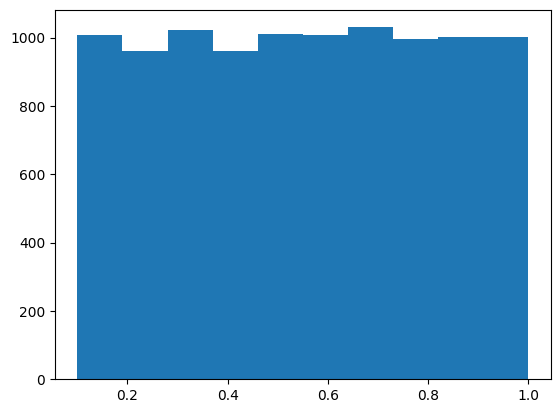

In [13]:
random_uniform_values = [np.random.uniform(high=1.0, low=0.1) for _ in range(10000)]
plt.hist(random_uniform_values)
# np.mean(random_uniform_values)

In [14]:
states_test =  Maze()
states_test.maze

array([[2., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 1., 1., 1.],
       [0., 0., 1., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 0.]])

In [15]:
agent_test = Agent(states_test.maze)
agent_test.init_reward(states_test.maze)
agent_test.G

{(0, 0): 0.2561846912877181,
 (1, 0): 0.7204644323783821,
 (2, 0): 0.8069644153619395,
 (3, 0): 0.44616629969680766,
 (4, 0): 0.31472982312891007,
 (5, 0): 0.9070924125055808,
 (0, 1): 0.4472961387303557,
 (1, 1): 0.2941932754922576,
 (2, 1): 0.3831892205653956,
 (3, 1): 0.8073633583255468,
 (4, 1): 0.9529661623596739,
 (5, 1): 0.23492472017679403,
 (0, 2): 0.25213461827075423,
 (1, 2): 0.840949100023281,
 (2, 2): 0.5004350979821767,
 (3, 2): 0.40031564662357566,
 (4, 2): 0.9029430531626867,
 (5, 2): 0.49072837477163844,
 (0, 3): 0.7113816009967243,
 (1, 3): 0.10041489775609379,
 (2, 3): 0.9694281305269996,
 (3, 3): 0.4580958622503858,
 (4, 3): 0.5905361643824565,
 (5, 3): 0.5377476960776553,
 (0, 4): 0.18192205449337123,
 (1, 4): 0.789127135460162,
 (2, 4): 0.7671353873348249,
 (3, 4): 0.6098770814311647,
 (4, 4): 0.944380611015498,
 (5, 4): 0.34880743143339055,
 (0, 5): 0.43729542014325573,
 (1, 5): 0.8105183444069807,
 (2, 5): 0.20516451259893592,
 (3, 5): 0.16005187523818237,
 (4, 

0
1000
2000
3000
4000


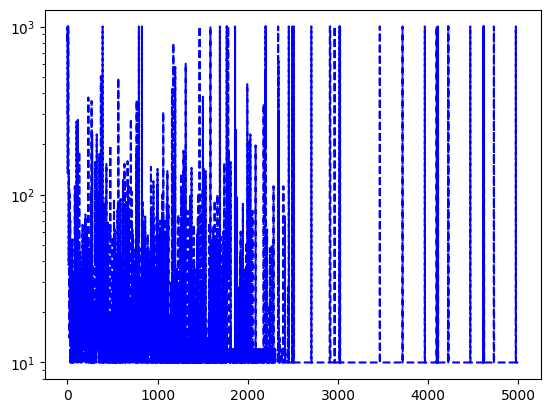

In [28]:
# import numpy as np
# from environment import Maze
# from agent import Agent
# import matplotlib.pyplot as plt

if __name__ == '__main__':
    maze = Maze()
    robot = Agent(maze.maze, alpha=0.1, random_factor=0.25)
    moveHistory = []

    for i in range(5000):
        if i % 1000 == 0:
            print(i)

        while not maze.isGameOver():
            state, _ = maze.get_state_and_reward() # get the current state 
            action = robot.choose_action(state, maze.allowed_states[state]) # choose an action (explore or exploit)
            maze.update_maze(action) # update the maze according to the action
            state, reward = maze.get_state_and_reward() # get the new state and reward
            robot.update_state_history(state, reward) # update the robot memory with state and reward
            if maze.steps > 1000:
                # end the robot if it takes too long to find the goal
                maze.robot_position = (5, 5)
        
        robot.learn() # robot should learn after every episode
        moveHistory.append(maze.steps) # get a history of number of steps taken to plot later
        maze = Maze() # reinitialize the maze

plt.semilogy(moveHistory, "b--")
plt.show()